# Bayesian Change Point Detection

## Background to the problem

In this project I will perform Bayesian analysis on a coal mining disasters data set (Jarrett 1979), which outlines the number of mining disasters that occurred in the UK, for each year between 1851 – 1962. As shown in Figure 1 below, the disaster rate wasn't constant during this period, and it's possible to identify a number of change points in the disaster rate.

Coal mining disasters have been responsible for substantial loss of life, and as such have seen significant regulation and trade union activity, aimed at increasing worker safety. The most significant change in the disaster rate appears around 1890, and is largely recognised as being due to the Coal Mines Regulations Act of 1887, which came into law on 1st January 1888.

In the years after this significant legislative change, the disaster rate is less consistent with periods where the rate is increasing and periods where it is decreasing, which Dwyer and Raftery (1991) argue is linked to the state of social relations in the workplace, with trade unionisation tending to decrease accidents, and factors leading to higher labour productivity, such as overtime, tending to cause an increase in accident rates.

During this project, I will attempt to identify such change points in the disaster rate, without commenting on what may have caused them.


In [1]:
library(boot)
data(coal)
head(coal) # data consists of list of dates of each disaster

,date
,<dbl>
1,1851.203
2,1851.632
3,1851.969
4,1851.975
5,1852.314
6,1852.347


In [2]:
year <- floor(min(coal$date)) : floor(max(coal$date)) # disasters between 1851-1962
n = length(year) # 112 years in data set (with varying numbers of disasters per year)

# y = number of disasters in each year
y <- tabulate(floor(coal[[1]]))
y <- y[year]

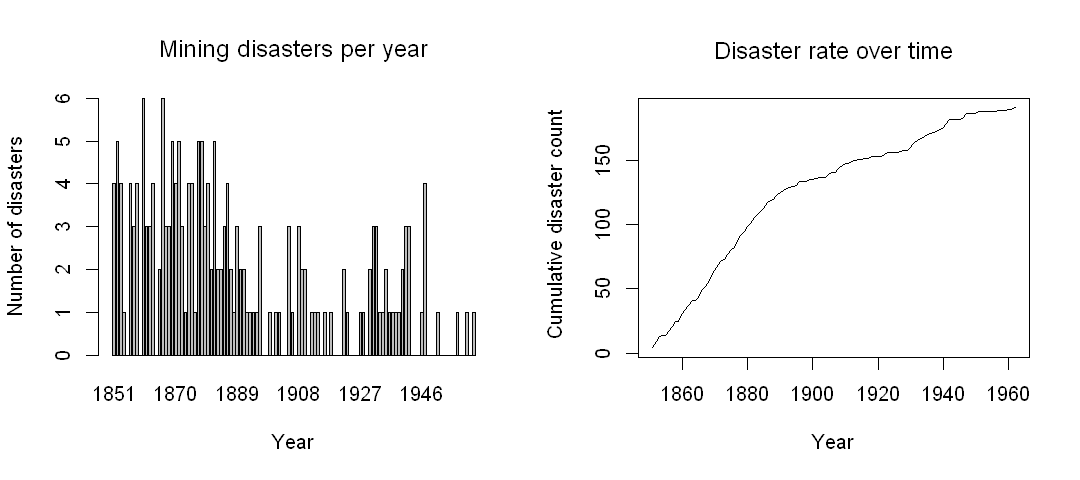

In [3]:
options(repr.plot.width=9, repr.plot.height=4) # set plot size
layout(matrix(c(1,2), nrow=1)) # figure with 2 plots
barplot(
    height=y, names=year,
    xlab="Year", ylab=expression(paste("Number of disasters")),
    main=expression(paste("Mining disasters per year"))
)
plot(
    x=year, y=cumsum(y), type="l",
    xlab="Year", ylab=expression(paste("Cumulative disaster count")),
    main=expression(paste("Disaster rate over time"))
)

**Figure 1**: *Plots showing the number of coal mining disasters each year (left), and the coal mining disaster rate over time (right), for the period 1851 to 1962. The plots show a higher number of disasters per year at the start of the period, with a relatively constant disaster rate during up until around 1890, after which the disaster rate decreased significantly. After this, there are a number of periods where the disaster rate increases, before again decreasing. In this project, I will attempt to locate change points in the disaster rate statistically, using Bayesian inference.*

### Constructing a model for the disaster rate, $\lambda_i$

To model the disaster rate, I will consider the number of mining disasters in year $i$, as coming from a Poisson process with an unknown rate $\lambda_i$.

For the simplest case, assuming a constant disaster rate with no change points, the number of disasters in year $i$, can be described by:

$y_i \sim \text{Poisson}(\lambda), \quad \text{for }i=1851,...,1962$

This simplest model corresponds to a straight line through the data, which we can see from the plots in Figure 1 is not a good fit for the data. To improve the fit, I will consider models with an increasing number of change points, where the disaster rate $\lambda$ is different between each change point.

For the case with 1 change point at year $T$, the number of disasters in year $i$ can be modelled by:

$y_i = \begin{cases}
    \text{Poisson}(\lambda_1)    & \quad    \text{for } i \lt T \\
    \text{Poisson}(\lambda_2)    & \quad    \text{for } i \ge T
\end{cases}$

where $\lambda_1$ and $\lambda_2$ represent the disaster rate before and after the change point at time $T$

For the case with two change points at T_1,T_2, the number of disasters in year i can be modelled by:

$y_i = \begin{cases}
    \text{Poisson}(\lambda_1)    & \quad    \text{for } i = 1851,...,(T_1 - 1) \\
    \text{Poisson}(\lambda_2)    & \quad    \text{for } i = T_1,...,(T_2 - 1) \\
    \text{Poisson}(\lambda_3)    & \quad    \text{for } i = T_2,...,1862 \\
\end{cases}$

And so on, for increasing numbers of change points.

The number of years in the dataset is given by $N = 112$, so the maximum possible number of change-points is $N-1 = 111$.

#### Prior selection

Bayesian statistics starts with a model of our prior belief about the likelihood of an event, which we then update using data, to return an updated posterior belief, which blends our observations with our original assumptions.

Once we've carefully chosen our prior distribution, $p(\theta)$, representing our prior belief about the probability distribution of the parameters in out model, $\theta$, we can calculate the posterior distribution given the data, $p(\theta | D)$, as follows:

$p(\theta | D) = \cfrac{p(D|\theta)p(\theta)}{p(D)} = \cfrac{p(D|\theta)p(\theta)}{\int p(D|\theta)p(\theta) \; \mathrm{d}\theta} = \cfrac{\text{likelihood} \times \text{prior}}{\text{evidence}}$

I will assume an ordered uniform prior on change point year $T=(T_1,\ldots,T_N)$, representing an assumption that all possible combinations of change points are equally likely, as given by:

$P(T_1,\ldots,T_N) = \begin{cases}
    \displaystyle\binom{111}{N}^{-1} & \text{for\ }1851 < T_1 < T_2 < \ldots < T_N \le 1962 \\
    \quad0 & \text{otherwise}
\end{cases}$

Finally I will assume $\text{Gamma}(\alpha=2, \beta=1)$ priors on all $\lambda_i$. 

$p(\lambda_i) \sim Ga(2,1)$

Therefore the prior probability density of each $\lambda_i$ is given by:

$p(\lambda_i) = 
  \cfrac{\beta^{\alpha} \lambda_i^{\alpha-1} e^{-\beta \lambda_i}}{\Gamma(\alpha)} =
  \cfrac{1^{2} \lambda_i^{2-1} e^{-1 \lambda_i}}{\Gamma(2)} =
  \cfrac{\lambda_i e^{-\lambda_i}}{1} =
  \lambda_i e^{-\lambda_i}$

Using gamma priors on $\lambda_i$ will simplify our calculations since the Gamma distribution is conjugate to our Poisson likelihood, and is an appropriate choice for our non-negative continuous data.

## Modelling a constant disaster rate

### Calculating the posterior analytically

For the simplest case, with no change-points, we can calculate the posterior distribution of the disaster rate $\lambda$ analytically, using conjugate updates, as outlined below:

$p(\lambda \mid y_{(1:N), \alpha, \beta}) 
    \;\propto\; p(y_{(1:N)} \mid \lambda) \times p(\lambda \mid \alpha, \beta)$

$\qquad\qquad\qquad\;\;\; 
    \propto\; \text{Poisson}(y_{(1:N)} \mid \lambda) \times \text{Gamma}(\lambda \mid \alpha, \beta)$

$\qquad\qquad\qquad\;\;\; 
    \propto\; \text{Gamma} \left( \alpha + \displaystyle\sum_{i=1}^{N} y_i, \; \beta + N \right)$

In [4]:
# log prior
log_prior <- function(lambda) {
    return(dgamma(lambda, 2, 1, log=TRUE))
}
# log likelihood
log_likelihood <- function(Y, lambda) {
    return(sum(dpois(Y, lambda, log=TRUE)))
}
# log posterior
a <- 2
b <- 1
log_posterior <- function(Y, lambda) {
    return(dgamma(lambda, a + sum(Y), b + length(Y)))
}

In [5]:
# evaluating analytical posterior density
lambda_grid <- seq(0, 10, 0.01) # for values of lambda between 0-10
lambda_post <- lambda_grid
for (i in 1:length(lambda_grid)) {
    lambda_post[i] <- exp(log_posterior(y, lambda_grid[i]))
}

The prior, posterior and predictive distributions for $\lambda$, in the no-change point case, are shown plotted in Figure 2 below. Our posterior has focused in around a most likely value of $\lambda$ somewhere between 1.5 and 2, and has diverged substantially from the prior, so we've learned a lot from our data.

However plotting our predicted disaster rate against the observed data, we can see that this model doesn't fit the data well, with most of the observations falling outside of the 95% predictive interval. This is what we expected to see, and is why we want to introduce change points in the disaster rate.

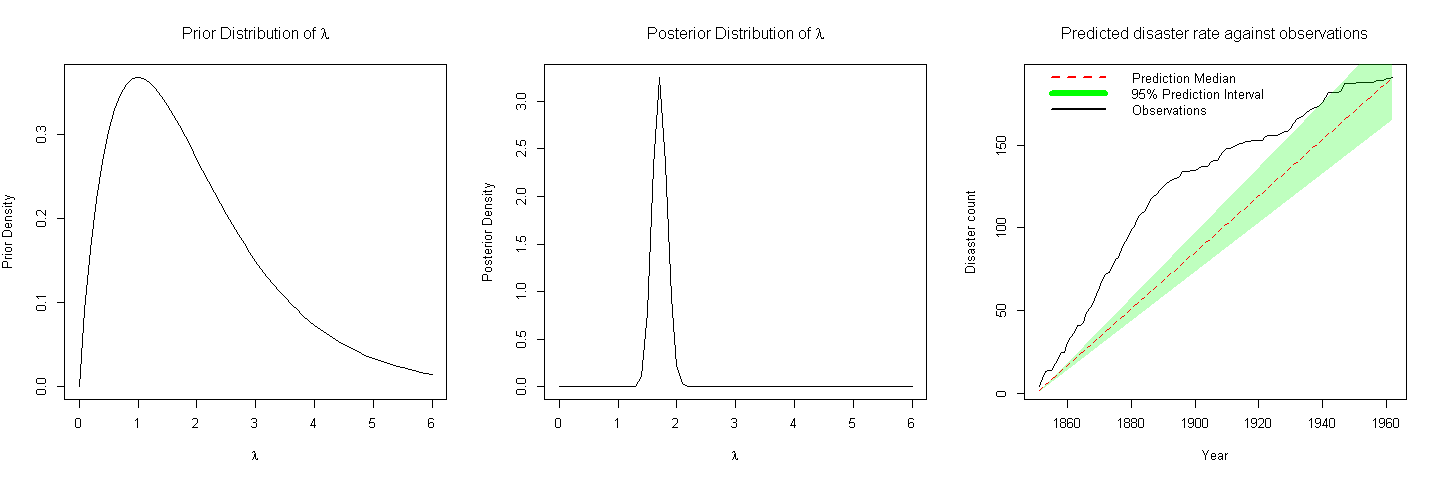

In [6]:
layout(matrix(c(1,2,3), nrow=1)) # figure with 3 plots
options(repr.plot.width=12, repr.plot.height=4) # set plot size

# plot of prior distribution of lambda
lambda_grid <- seq(0, max(y), by=0.1) # define sequence of possible values for lambda
plot(
    lambda_grid, exp(log_prior(lambda_grid)), type="l",
    xlab=expression(lambda),
    ylab=expression(paste("Prior Density")),
    main=expression(paste("Prior Distribution of ",lambda))
)

# plot posterior distribution of lambda
plot(
    lambda_grid, log_posterior(y, lambda_grid), type="l",
    xlab=expression(lambda),
    ylab=expression(paste("Posterior Density")),
    main=expression(paste("Posterior Distribution of ",lambda))
)

# plot observed data against 95% posterior prediction interval
predictive_interval_analytical <- function(title){
    lambda_CI <- c(
        qgamma(0.025, a + sum(y), b + length(y)),
        qgamma(0.975, a + sum(y), b + length(y))
    )
    lambda_median <- qgamma(0.5, a + sum(y), b + length(y))
    plot(
        x=year, y=cumsum(y), type="l",
        xlab="Year", ylab=expression(paste("Disaster count")),
        main=title, font.main=1
    )
    polygon(
        c(year[1], year[n], year[n], year[1]),
        c(1, lambda_CI[2]*n, lambda_CI[1]*n, 1),
        col=adjustcolor("green", alpha.f=0.25),
        border=NA
    )
    lines(x=year, y=lambda_median * 1:length(year), col="red", lty=2)

    # add legend
    legend("topleft", #inset = 0.1,
        c("Prediction Median","95% Prediction Interval","Observations"), # labels
        col=c("red","green","black"), # line colours
        lty=c(2, 1, 1), # line types
        lwd=c(2, 5, 2), # line widths
        y.intersp=2, # increase spacing
        bty="n") # remove border
}
predictive_interval_analytical("Predicted disaster rate against observations")

**Figure 2**: *Prior, posterior and predictive plots for the model with 0 change-points, calculated analytically. The first two panels show the prior (left) and posterior (mid) of the accident rate $\lambda$. The final panel (right) shows the predictive distribution of $y_i$, plotted against the observed data, with the predicted median value in red, and a 95% prediction interval highlighted green. The data mostly falls outside the 95% prediction interval, so this model does not explain the data well.*

### Metropolis-Hasting Sampler for constant disaster rate

The Metropolis-Hastings algorithm (Hastings 1970) is a Monte Carlo Markov Chain (MCMC) dependent sampling algorithm, based on running a number of independent Markov chains, which each perform a random walk over the parameter space.

At each iteration of the algorithm, new steps are accepted into the posterior based on a probabilistic comparison with the previous step. If constructed correctly, this means that once a Markov chain has found the posterior distribution, it should move around but not significantly beyond the posterior, so that the independent chains converge on the posterior distribution. 

I started by building a Metropolis-Hastings samplers for the simplest case with 0 change points, so that I could compare the results against the analytically calculated posterior, before extending the model to 1 or more change points.

For my implementation of Metropolis-Hastings, I used a normal distribution for the proposal step, and found that a standard deviation of 0.2 provided good performance, with an acceptance rate around 56% (this is a good level of acceptance for our problem, balancing the efficiency and thoroughness of the search).

I used log transformations on the prior, posterior and likelihood functions to increase the efficiency of the algorithm, and ran 4 independent Markov chains, running 100,000 samples in each.

In [7]:
# Metropolis sampler for the log posterior
m <- 100000 # number of samples
lambda <- matrix(0, nrow=m, ncol=4) # init 4 chains of m samples
lambda[1,] <- rgamma(4, 2, 1) # start chains with random draws from Gamma(2,1) lambda prior
accepted <- rep(1,4) # counter for calculating acceptance rate
for (step in 2:m) {
    for(chain in 1:4){
        proposed <- rnorm(1, lambda[step-1, chain], 0.2)
        if (proposed >= 0) {
            r <- exp(log_prior(proposed) + log_likelihood(y,proposed) - log_prior(lambda[step-1, chain]) - log_likelihood(y,lambda[step-1, chain]))
        } else {
            r <- 0
        }
        u <- runif(1)
        if (u < r) {
            accepted[chain] <- accepted[chain] + 1 # increment accepted count
            lambda[step, chain] <- proposed
        } else {
            lambda[step, chain] <- lambda[step-1, chain]
        }
    }
}
print(accepted/m*100) # print acceptance rate

[1] 56.358 56.348 56.514 56.403


#### Convergence

The biggest problem with the Metropolis-Hastings algorithm is that although in theory, if correctly constructed, the chains are guaranteed to converge eventually, it is not possible to know for certain when or if the chains have converged, and for complex multi-modal distributions where high-density regions are connected by areas of very low probability, it can appear that the chains have converged, when in fact large areas of the posterior have not yet been explored.

In this example, we are able to plot our sampled posterior predictive distributions against the observed data, making it simple to compare visually, even with increasing numbers of parameters. However I will also check the Trace plots, and consider the Gelman-Rubin statistic, proposed by Gelman and Rubin (1992), which compares the variance within chains to the variance between chains, to assess the convergence of chains. When this statistic is close to 1, the difference between the variance within and between chains is small, giving support for the chains having converged, although we can never be certain.

##### Trace plots

As shown below, the trace plots for each chain look healthy with good mixing, and the chains appeared to converge quickly after a short burn-in.

In [8]:
require(coda)

# convert chains into mcmc objects (single chain per object, each col = single variable)
mcmc_1 <- mcmc(lambda[,1])
mcmc_2 <- mcmc(lambda[,2])
mcmc_3 <- mcmc(lambda[,3])
mcmc_4 <- mcmc(lambda[,4])

varnames(mcmc_1) <- "Chain 1"
varnames(mcmc_2) <- "Chain 2"
varnames(mcmc_3) <- "Chain 3"
varnames(mcmc_4) <- "Chain 4"

Loading required package: coda



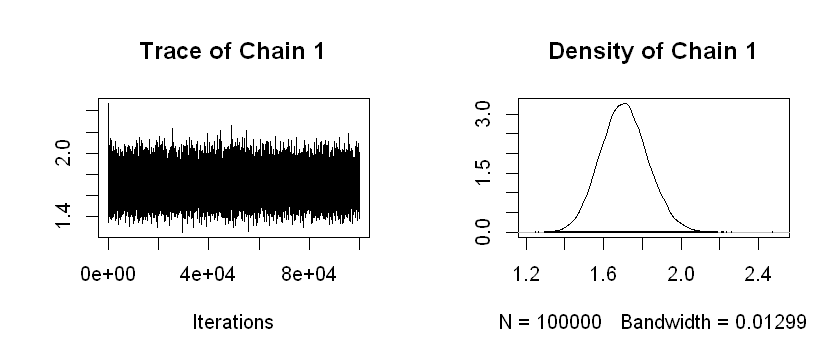

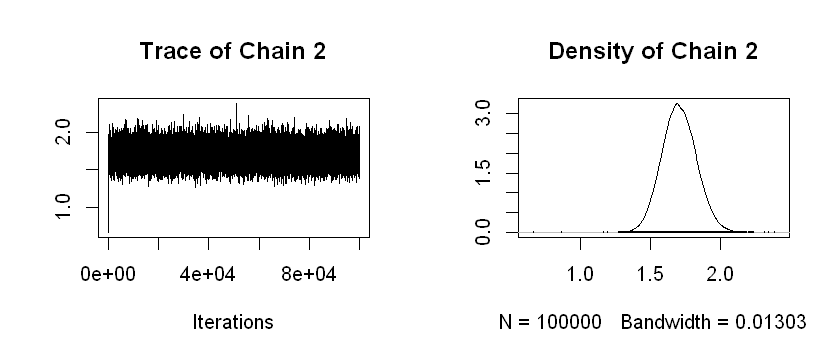

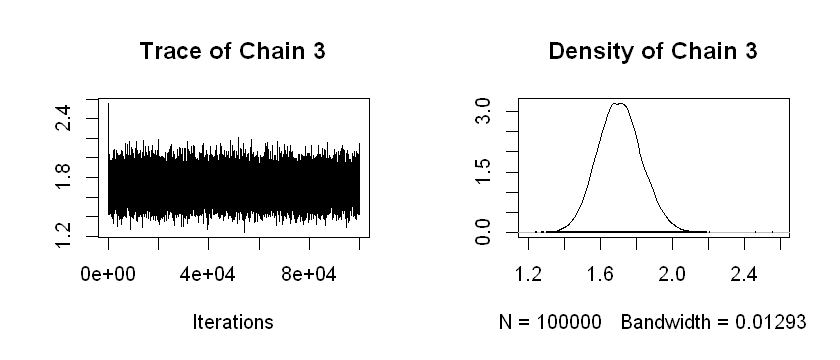

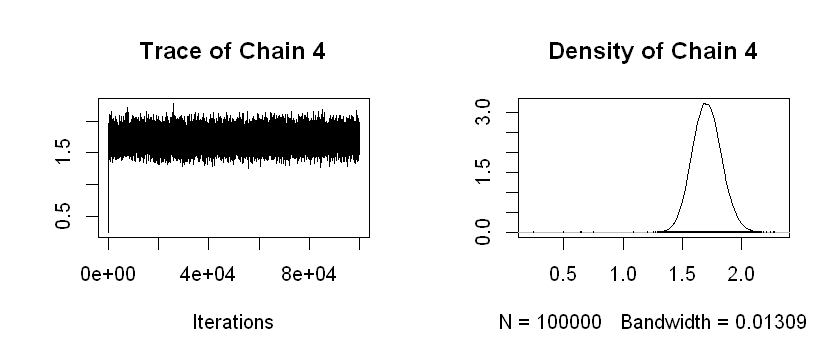

In [9]:
# plot traces and densities for each chain
options(repr.plot.width=7, repr.plot.height=3) # set plot size

plot(mcmc_1)
plot(mcmc_2)
plot(mcmc_3)
plot(mcmc_4)

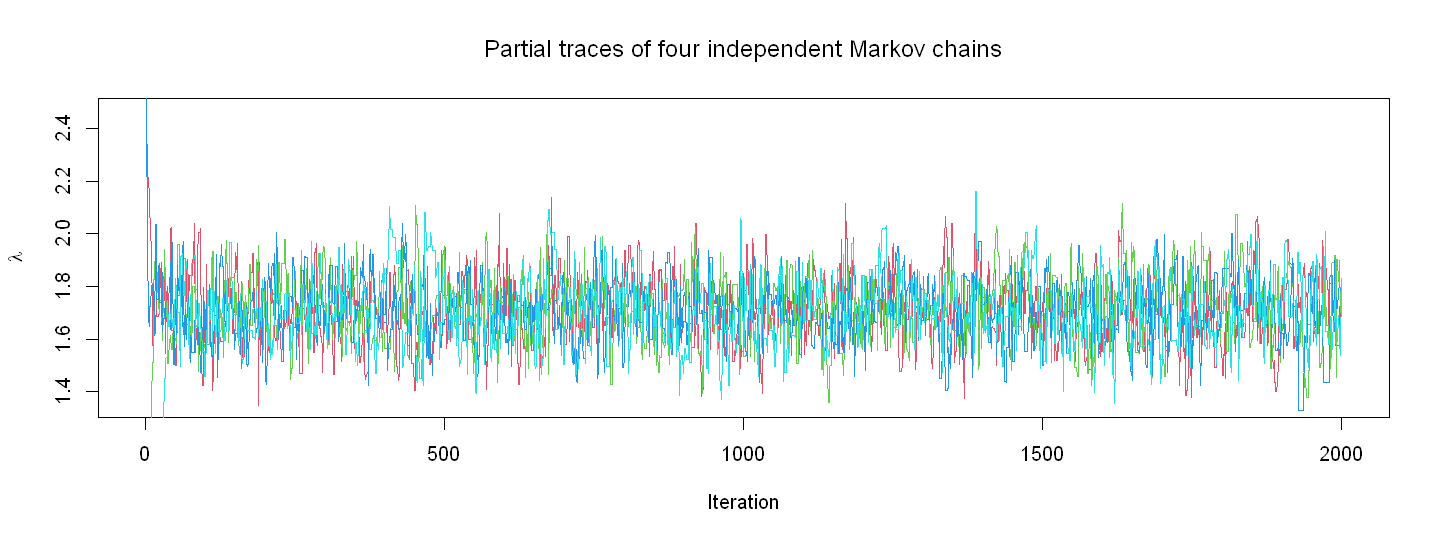

In [10]:
# plot first 2000 iterations of each chain
i = 1
j = 2000
options(repr.plot.width=12, repr.plot.height=4.5) # set plot size
plot(
    i:j, lambda[i:j, 1], type="l", col=2,
    main = expression(paste("Partial traces of four independent Markov chains")),
    xlab = "Iteration", ylab = expression(lambda)
)
lines(i:j, lambda[i:j, 2], type="l", col=3)
lines(i:j, lambda[i:j, 3], type="l", col=4)
lines(i:j, lambda[i:j, 4], type="l", col=5)

##### Summary statistics

Each chain returned the same mean and median values for $\lambda$ of 1.71, correct to 2 dp, suggesting that our chains have converged on the true value.

In [11]:
# mean values for each chain
summary(mcmc_1)$statistics["Mean"]
summary(mcmc_2)$statistics["Mean"]
summary(mcmc_3)$statistics["Mean"]
summary(mcmc_4)$statistics["Mean"]

Mean 
1.707078

Mean 
1.707663

Mean 
1.707642

Mean 
1.707596

In [12]:
# median values for each chain
summary(mcmc_1)$quantiles[3]
summary(mcmc_2)$quantiles[3]
summary(mcmc_3)$quantiles[3]
summary(mcmc_4)$quantiles[3]

50% 
1.704536

50% 
1.704638

50% 
1.705213

50% 
1.70534

##### Gelman-Rubin Diagnostic

As shown below, Gelman-Rubin Diagnostic returned for my chains is very close to 1, providing good support for the chains having converged.

In [13]:
# Gelman-Rubin Statistic
chainlist <- mcmc.list(
    Chain1=mcmc(lambda[,1]),
    Chain2=mcmc(lambda[,2]),
    Chain3=mcmc(lambda[,3]),
    Chain4=mcmc(lambda[,4])
)
gelman.diag(chainlist)$psrf # potential scale reduction factor
as.numeric(gelman.diag(chainlist)$psrf[1,2]) # if this value is close to 1, this suggests the chains have converged

Point est.,Upper C.I.
1,1.000018


[1] 1.000018

##### Predictive Distribution

In [14]:
# Use direct sampling from our sampled posterior, to check if your predictions look correct

# remove first 1000 iterations as burn-in
post_sample <- lambda[1000:m,]

# draw from the posterior predictive distribution
pred_sample <- matrix(0, nrow=length(post_sample), ncol=length(year)) # sample for each year
for (i in 1:length(post_sample)) {
    pred_sample[i,] <- cumsum(rpois(length(year), post_sample[i])) # sample from poisson, using lambda from sample
}

# evaluate posterior predictive quantiles
pred_sample_quantiles <- matrix(0, nrow=3, ncol=length(year))
for (i in 1:length(year)) {
    pred_sample_quantiles[,i] <- quantile(pred_sample[,i], probs=c(0.025,0.5,0.975))
}

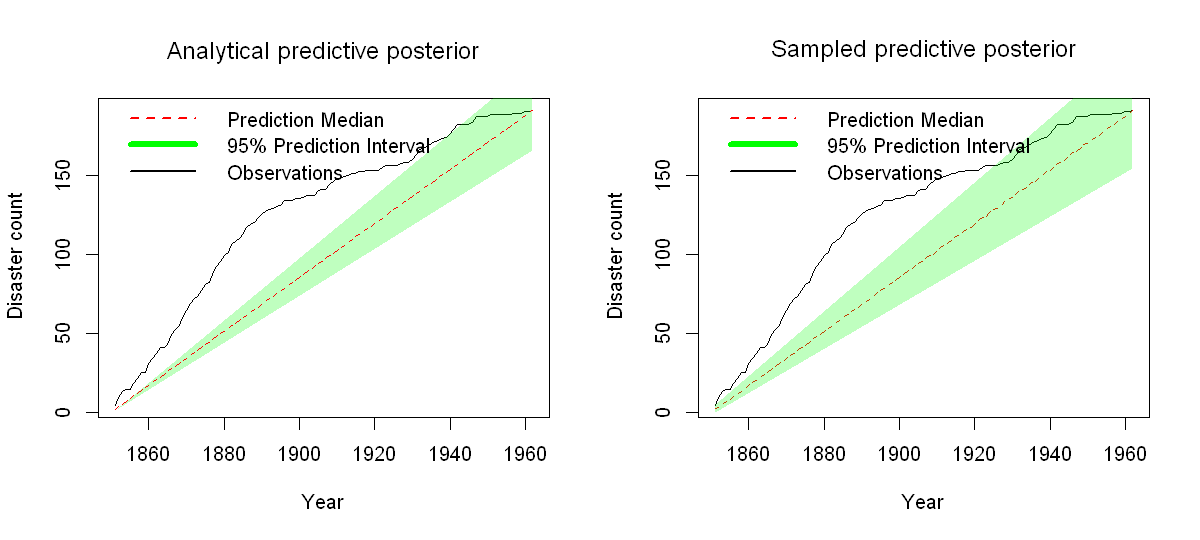

In [15]:
layout(matrix(c(1,2), nrow=1)) # figure with 3 plots
options(repr.plot.width=10, repr.plot.height=4.5) # set plot size

# plot analytical predictive distribution
predictive_interval_analytical(title="Analytical predictive posterior")

# plot sampled predictive distribution
plot(
    x=year, y=cumsum(y), type="l",
    xlab="Year", ylab=expression(paste("Disaster count")),
    main=expression(paste("Sampled predictive posterior"))
)
lines(year, pred_sample_quantiles[2,],col="red", lty=2)
polygon(
    c(year[1], year[n], year[n], year[1]),
    c(pred_sample_quantiles[1,1], pred_sample_quantiles[1,n], pred_sample_quantiles[3,n], pred_sample_quantiles[3,1]),
    col=adjustcolor("green", alpha.f=0.25),
    border=NA
)
legend("topleft", #inset = 0.1,
    c("Prediction Median","95% Prediction Interval","Observations"), # labels
    col=c("red","green","black"), # line colours
    lty=c(2, 1, 1), # line types
    lwd=c(2, 5, 2), # line widths
    y.intersp=2, # increase spacing
    bty="n") # remove border

The predictive distribution calculated by my sampler (right) is very similar to that calculated analytically (left).

##### Compare sampled vs analytical distribution of $\lambda$

Finally my sampler produced results comparable to computing the posterior analytically, as shown below.

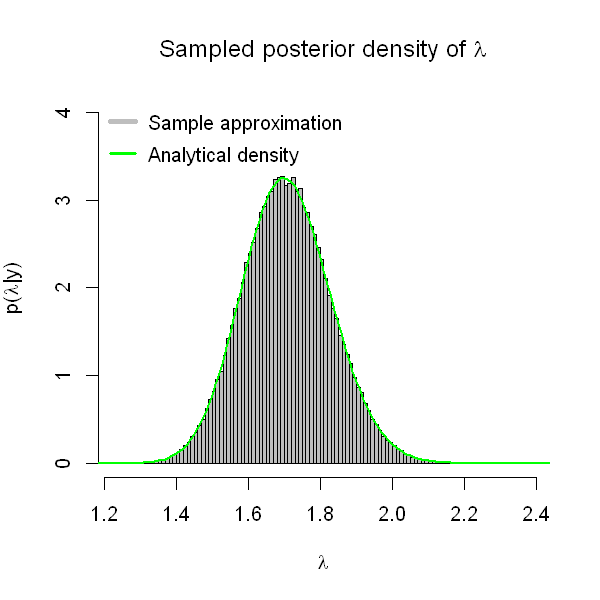

In [16]:
# plot sample as density histogram
options(repr.plot.width=5, repr.plot.height=5) # set plot size
hist(
    post_sample, prob=T, col="grey", breaks=100,
    main = expression(paste("Sampled posterior density of ",lambda)),
    xlab = expression(lambda),
    ylab = expression(paste("p(",lambda,"|y)")),
    ylim=c(0,4)
)
# add line for analytical density of posterior = Gamma(2 + sum(y_i), 1 + n)
lambda_grid <- seq(0, max(y), by=0.01) # sequence of possible values for lambda
lines(
    x=lambda_grid,
    y=log_posterior(y, lambda_grid),
    col="green", lwd=2
)
# add legend
legend("topleft", #inset = 0.1,
    c("Sample approximation","Analytical density"), # labels
    col=c("grey","green"), # line colours
    lty=c(1, 1), # line types
    lwd=c(4, 2.5), # line widths
    y.intersp=2, # increase spacing
    bty="n") # remove border 

However, whilst this shows that my sampler provides a good approximation of the posterior for 0 change points, we've already seen that the 0 change point model doesn't describe the data well, so we will now start adding change points into our model.

## One change-point model

To increase the fit of the model, I'll now consider the case where we allow for a single change point in the disaster rate at year $T$, and use Bayesian inference to infer the most likely change point year, and the disaster rate before and after the disaster rate, $\lambda_1,\lambda_2$.

For the one-change point model, we want to infer 3 parameters, $\lambda_1, \lambda_2, T$, and the joint posterior distribution is given by:

$p(\lambda_1, \lambda_2, T \mid y_{(1:N)}, \alpha, \beta) \; \propto \; 
    p(y_{(1:T-1)} \mid \lambda_1) \times p(\lambda_1 \mid \alpha, \beta) \times 
    p(y_{(T:N)} \mid \lambda_2) \times p(\lambda_2 \mid \alpha, \beta) \times 
    p(T)$

$\qquad\qquad\qquad\qquad\qquad\;\;\, \propto \; 
    \text{Poi}(y_{(1:T-1)} \mid \lambda_1) \times \text{Ga}(\lambda_1 \mid \alpha, \beta) \times
    \text{Poi}(y_{(T:N)} \mid \lambda_2) \times \text{Ga}(\lambda_2 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\qquad\;\;\,\propto
    \displaystyle\prod_{i=1}^{T-1}\frac{\lambda_1^{y_i}e^{-\lambda_1}}{y_i!}\ \times\ \prod_{i=T}^{N}\frac{\lambda_2^{y_i}e^{-\lambda_2}}{y_i!}\ {\times\ \lambda}_1e^{-\lambda_1}\ \times\ \lambda_2e^{-\lambda_2}$


$\qquad\qquad\qquad\qquad\qquad\;\;\,\propto
    \displaystyle\frac{{\lambda_1}^{\sum_{i=1}^{T-1}y_i}\ \ e^{-(T-1)\lambda_1}}{\prod_{i=1}^{T-1}{y_i!}}\ \times\frac{{\lambda_2}^{\sum_{i=T}^{N}y_i}\ \ e^{-(N-T)\lambda_2}}{\prod_{i=T}^{N}{y_i!}}\ {\times\ \lambda}_1e^{-\lambda_1}\ \times\ \lambda_2e^{-\lambda_2}$

$\qquad\qquad\qquad\qquad\qquad\;\;\,\propto
    {\lambda_1}^{\sum_{i=1}^{T-1}y_i}\ e^{-(T-1)\lambda_1}\ \times\ {\lambda_2}^{\sum_{i=T}^{N}y_i}\ \ e^{-\left(N-T\right)\lambda_2} {\times\ \lambda}_1e^{-\lambda_1}\ \times\ \lambda_2e^{-\lambda_2}$

Where we can drop the $P(T)$ term as a constant of proportionality

### Gibbs Sampler

After struggling to extend my Metropolis-Hastings algorithm beyond the 0 change-point case, I decided to change my approach and attempted to implement a Gibbs sampler for the problem.

The Gibbs algorithm, proposed by Geman and Geman (1984), is another MCMC dependent sampling method, which involves running a set of Markov chains, which explore the parameter space, until they converge on the posterior distribution.

Instead of proposing a step randomly and deciding if we want to move to it, as we do in the Metropolis-Hastings algorithm, the Gibbs algorithm decides the next step based on the conditional probability of one parameter at a time, holding the others constant at their most recently calculated value, so that we move around the $k$-dimensional parameter space, moving in the $k$-th direction at each step. In a 2-dimensional problem, where we are using Gibbs to infer the density of 2 parameters, this corresponds to moving up and down, or left and right, on a cartesian plane, whereas in a Metropolis-Hastings algorithm we might move in any direction.

This means that, in contrast to the Metropolis-Hastings algorithm, all proposed steps are accepted, so it can be a significantly more efficient algorithm for problems where it is possible to construct a Gibbs sampler, and depending on the correlation of variables.

#### Conditional Distributions for 1 change point

To use a Gibbs sampler, we need to be able to define the full conditional distribution of all parameters we want to sample with Gibbs. We will then use these conditional distributions to hold the other parameters constant and sample from one parameter at a time, moving over the $k$-dimensional sample space, where $k$ is the number of parameters we're performing inference on, 3 in the one change-point model.

Since our gamma priors on $\lambda_i$ are conjugate to the poisson likelihood, we have:

$p(\lambda_1 \mid y_{(1:T-1)}, T, \alpha, \beta) \; \propto \; 
    p(y_{(1:T-1)} \mid \lambda_1) \times p(\lambda_1 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\;\;\,\, \propto \; 
    \text{Poi}(y_{(1:T-1)} \mid \lambda_1) \times \text{Ga}(\lambda_1 \mid \alpha, \beta)$ 

$\qquad\qquad\qquad\qquad\;\;\,\, \sim 
    \text{Gamma}(\alpha + \displaystyle\sum_{i=1}^{T-1} y_i, \beta + T - 1)$

And similarly:

$p(\lambda_2 \mid y_{(T:N)}, T, \alpha, \beta) \; \propto \; 
    p(y_{(T:N)} \mid \lambda_2) \times p(\lambda_2 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\qquad\, \propto \; 
    \text{Poi}(y_{(T:N)} \mid \lambda_2) \times \text{Ga}(\lambda_2 \mid \alpha, \beta)$ 

$\qquad\qquad\qquad\qquad\qquad\, \sim 
    \text{Gamma}(\alpha + \displaystyle\sum_{i=T}^{N} y_i, \beta + N - T)$

In [17]:
# return 1 sample of lambda_1, for given values of T,a,b
lambda_1_sample <- function(Y, T, a=2, b=1){ # default values from prior
    return(rgamma(1, (a + sum(Y[1:(T-1)])), (b + T - 1)))
}

# return 1 sample of lambda_2, for given values of T,a,b
lambda_2_sample <- function(Y, T, a=2, b=1){  # default values from prior
    N <- length(Y)
    return(rgamma(1, (a + sum(Y[T:N])), (b + N - T)))
}

Our conditional distribution for $T$ is given by:

$p(T \mid y_{(1:N)}, \lambda_1, \lambda_2) \; \propto \; 
    p(y_{(1:T-1)} \mid \lambda_1) \times p(y_{(T:N)} \mid \lambda_2) \times p(T)$

$\qquad\qquad\qquad\qquad\;\, \propto \; 
    \text{Poi}(y_{(1:T-1)} \mid \lambda_1) \times
    \text{Poi}(y_{(T+1:N)} \mid \lambda_2) \times 1$

$\qquad\qquad\qquad\qquad\;\, \propto \; 
    \displaystyle\prod_{i=1}^{T-1} \cfrac{\lambda_1^{y_i} e^{-\lambda_1}}{y_i!} \times 
    \displaystyle\prod_{i=T}^{N} \cfrac{\lambda_2^{y_i} e^{-\lambda_2}}{y_i!}$

$\qquad\qquad\qquad\qquad\;\, \propto \; 
    \cfrac{\lambda_1^{\sum_{i=1}^{T-1} y_i} e^{-(T-1) \lambda_1}}{\prod_{i=1}^{T-1} y_i!} \times 
    \cfrac{\lambda_2^{\sum_{i=T}^{N} y_i} e^{-(N-T) \lambda_2}}{\prod_{i=T}^{N} y_i!}$

$\qquad\qquad\qquad\qquad\;\, \propto \; 
    \lambda_1^{\sum_{i=1}^{T-1} y_i} e^{-(T-1) \lambda_1} \times 
    \lambda_2^{\sum_{i=T}^{N} y_i} e^{-(N-T) \lambda_2} $

Note that we're able to drop the $P(T)$ and the $y_i!$ terms in the above as constants of proportionality.

In [18]:
# for each possible value of T in N, return conditional probability of T, for given values of lambda_1 and lambda_2
T_conditional <- function(Y, lambda_1, lambda_2){
    N <- length(Y)
    T_prob <- rep(0, N)
    for(T in 1:N){
        # probability of change-point at last time step is 0
        if (T == N){
            T_prob[T] = 0
        }else{
            T_prob[T] = lambda_1^(sum(Y[1:(T-1)])) * exp(-(T-1)*lambda_1) * lambda_2^(sum(Y[T:N])) * exp(-(N-T)*lambda_2)
        }
    }
    # normalise to return density
    return(T_prob / sum(T_prob))
}

# take sample of n for given values of lambda_1, lambda_2
T_sample <- function(Y, lambda_1, lambda_2){
    return(
        sample(seq(1:length(Y)), 1, prob=T_conditional(Y, lambda_1, lambda_2))
    )
}

##### Gibbs Sampler for 1 change point

In [40]:
m <- 100000 # number of samples
post_sample <- matrix(nrow=m, ncol=3) # init matrix for chains, with col for each variable we're sampling

# initialise chain for each parameter
# parameter order: lambda_1, lambda_2, T
post_sample[1,] <- c(
    rgamma(1, 2, 1),                # lambda_1 from Gamma(2,1)
    rgamma(1, 2, 1),                # lambda_2 from Gamma(2,1)
    sample.int(n=length(y), size=1) # T from Uniform(1851:1962)
)
post_sample[1,] # starting values

[1]   2.998865   1.848174 104.000000

In [41]:
# run Gibbs sampler to m iterations
for(step in 2:m){
    # lambda_1 (using previously calculated T, col 3)
    post_sample[step, 1] = lambda_1_sample(Y=y, T=post_sample[(step-1),3], a=2, b=1)

    # lambda_2 (using previously calculated T, col 3)
    post_sample[step, 2] <- lambda_2_sample(Y=y, T=post_sample[(step-1),3], a=2, b=1)

    # T (using lambda_1, lambda_2 calculated in this iteration)
    post_sample[step, 3] <- T_sample(Y=y, lambda_1=post_sample[step, 1], lambda_2=post_sample[step, 2])
}

In [42]:
# our approximated posterior is stored in sample
colnames(post_sample) <- c("lambda_1", "lambda_2", "T")
post_sample <- as.data.frame(post_sample)

In [43]:
data.frame(
    "median lambda_1" = median(post_sample$lambda_1),
    "median lambda_2" = median(post_sample$lambda_2),
    "median year number" = median(post_sample$T),
    "median year" = median(post_sample$T) + year[1]-1
)

median.lambda_1,median.lambda_2,median.year.number,median.year
<dbl>,<dbl>,<dbl>,<dbl>
3.085237,0.9460311,41,1891


##### Checking convergence

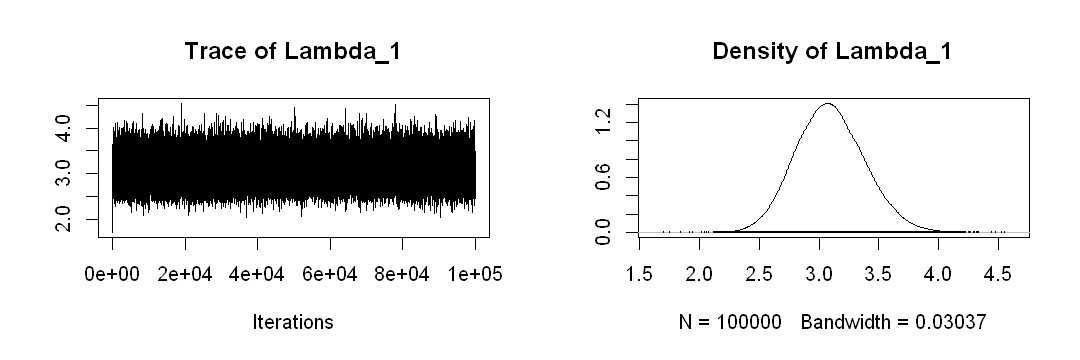

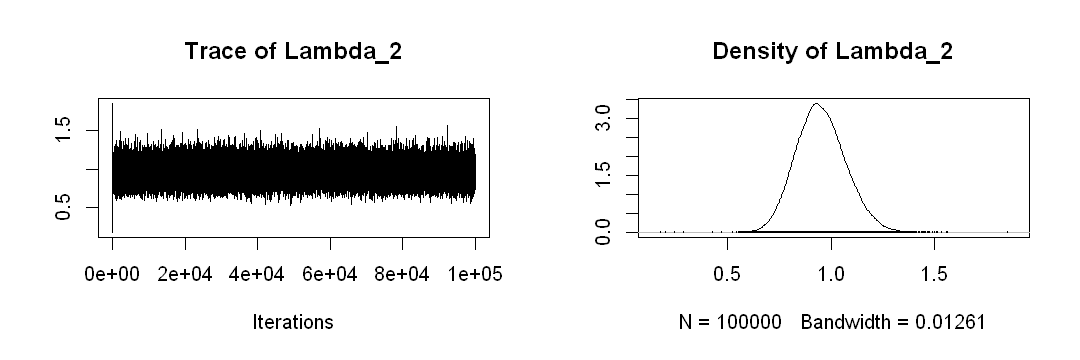

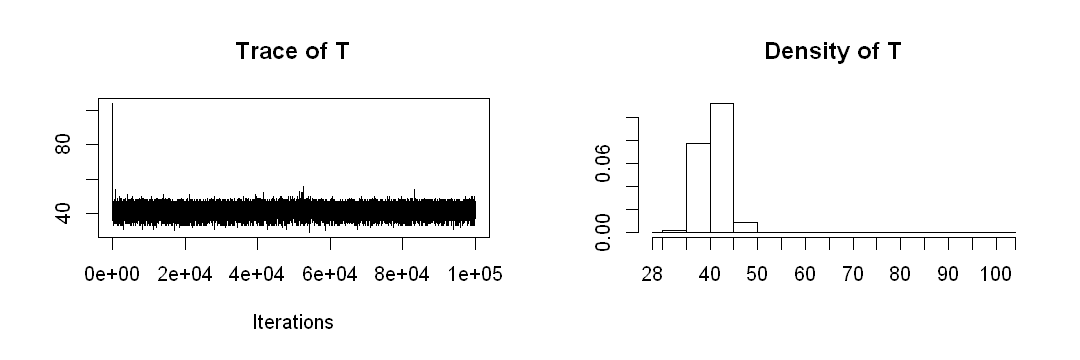

In [44]:
require(coda)

# convert chains into mcmc objects
mcmc_lambda_1 <- mcmc(post_sample$lambda_1)
mcmc_lambda_2 <- mcmc(post_sample$lambda_2)
mcmc_T <- mcmc(post_sample$T)

# assign names to mcmc objects
varnames(mcmc_lambda_1) <- "Lambda_1"
varnames(mcmc_lambda_2) <- "Lambda_2"
varnames(mcmc_T) <- "T"

options(repr.plot.width=9, repr.plot.height=3) # set plot size
plot(mcmc_lambda_1)
plot(mcmc_lambda_2)
plot(mcmc_T)

The traces look like they've converged, and the mostly likey value of change-point $T$ appears around year 41, which is what we see in the data, so this seems reasonable.

#### Resulting approximated posterior distribution for model with 1 change-point

In [45]:
# remove first 1000 samples as burn-in
post_sample_reduced <- post_sample[1000:m,]

length(post_sample_reduced[,1]) # remaining samples

[1] 99001

In [46]:
# frequency table
table(post_sample_reduced$T)

as.integer(names(table(post_sample_reduced$T)[which.max(table(post_sample_reduced$T))])) # most frequent value


   29    30    31    32    33    34    35    36    37    38    39    40    41 
    1     2     9    10   234   229   224   813  8845 10335  3805 14737 17958 
   42    43    44    45    46    47    48    49    50    51    52    53    54 
23239  9088  3725  1584   658  2995   407    67    26     4     3     1     1 
   56 
    1 

[1] 42

In [47]:
lambda_1_density <- density(post_sample_reduced$lambda_1,n=100)
lambda_1_MAP <- lambda_1_density$x[which.max(lambda_1_density$y)]

lambda_2_density <- density(post_sample_reduced$lambda_2,n=100)
lambda_2_MAP <- lambda_2_density$x[which.max(lambda_2_density$y)]

In [48]:
# extract point estimates
T_MAP <- as.integer(names(sort(-table(post_sample_reduced$T)))[1]) + (year[1] - 1) # equivalent year
T_median <- median(post_sample_reduced$T) + (year[1] - 1)
lambda_1_median <- median(post_sample_reduced$lambda_1)
lambda_2_median <- median(post_sample_reduced$lambda_2)
data.frame(
    "lambda_1_median"=lambda_1_median,
    "lambda_2_median"=lambda_2_median,
    "T_median"=T_median,
    "T_MAP"=T_MAP,
    "lambda_1_MAP"=lambda_1_MAP,
    "lambda_2_MAP"=lambda_2_MAP
)

lambda_1_median,lambda_2_median,T_median,T_MAP,lambda_1_MAP,lambda_2_MAP
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.085263,0.9460192,1891,1892,3.066427,0.9241233


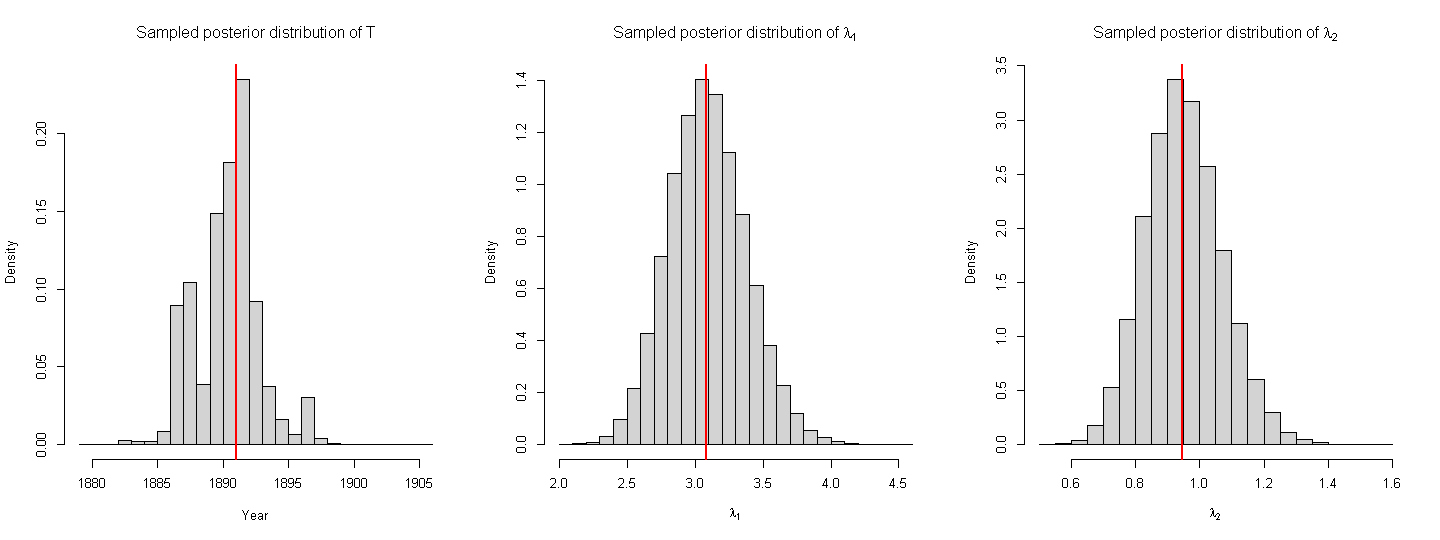

In [49]:
options(repr.plot.width=12, repr.plot.height=4.5) # set plot size
layout(matrix(c(1,2,3), nrow=1)) # figure with 3 plots

hist(
    post_sample_reduced$T + (year[1] - 1),
    prob="T", breaks=20,
    xlab="Year",
    main=expression(paste("Sampled posterior distribution of T"))
)
abline(v=T_median, col="red", lwd=2)

hist(
    post_sample_reduced$lambda_1,
    prob="T", breaks=20,
    xlab=expression(lambda[1]),
    main=expression(paste("Sampled posterior distribution of ",lambda[1]))
)
abline(v=lambda_1_median, col="red", lwd=2)

hist(
    post_sample_reduced$lambda_2,
    prob="T", breaks=20,
    xlab=expression(lambda[2]),
    main=expression(paste("Sampled posterior distribution of ",lambda[2]))
)
abline(v=lambda_2_median, col="red", lwd=2)


#### Posterior preditive distribution

The posterior predictive distribution, $p(\tilde{y}|y)$ can be approximated by taking samples from the posterior distribution that we've approximated with Gibbs, and plugging those sampled values into our sampling distribution $\tilde{y_i} \sim p(\tilde{y}|T_i) = Poi(\lambda)$, where $\lambda = \lambda_1$ for $i \lt T_i$, and $\lambda_2$ for $i \ge T_i$

In [50]:
pred_m <- length(post_sample_reduced$T) # num samples from predictive distribution
pred_sample <- matrix(0, nrow=pred_m, ncol=length(year)) # row for each sample, col for each possible value of T

for (step in 1:pred_m){
    for (i in 1:length(year)){
        # sample Ti from our posterior (previously approximated with Gibbs)
        Ti <- sample(post_sample_reduced$T, 1)

        # for each change-point Ti, calculate sampling distribution of yi_tilde, given that value of Ti
        if (i < Ti){
            # sample from sampling distribution using lambda_1 if sampled year is before change year Ti
            pred_sample[step,i] <- rpois(1, post_sample_reduced$lambda_1)
        }else{
            # else sample using lambda_2
            pred_sample[step,i] <- rpois(1, post_sample_reduced$lambda_2)
        }
    }
}

In [51]:
# build quantiles from sample
cum_pred <- t(apply(pred_sample,1,cumsum))

median_T <- rep(0,length(year))
lower_T <- rep(0,length(year))
upper_T <- rep(0,length(year))

for (i in 1:length(year)){
    lower_T[i] <- quantile(cum_pred[,i], probs=c(0.025))
    median_T[i] <- quantile(cum_pred[,i], probs=c(0.5))
    upper_T[i] <- quantile(cum_pred[,i], probs=c(0.975))
}

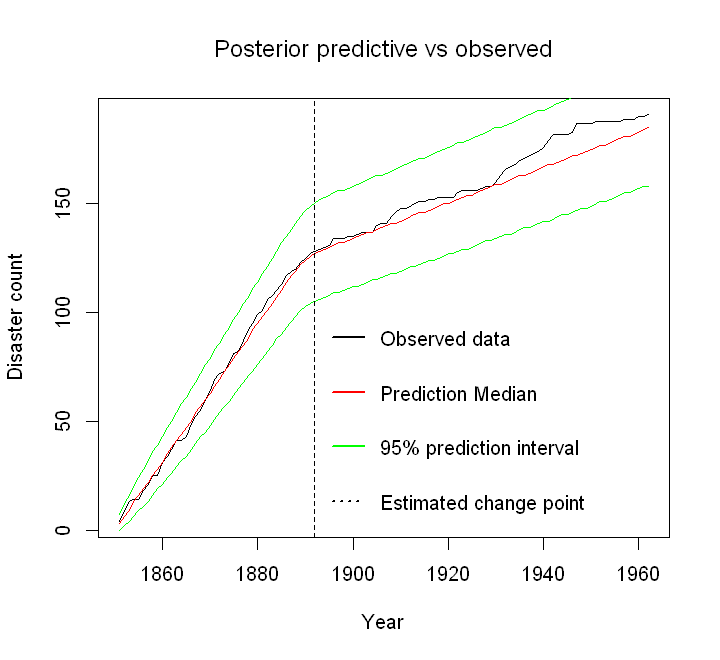

In [52]:
options(repr.plot.width=6, repr.plot.height=5.5) # set plot size
plot(
    year, cumsum(y), type="l",
    main=expression("Posterior predictive vs observed"),
    ylab="Disaster count", xlab="Year"
)
lines(year, median_T, col="red")
lines(year, lower_T, col="green")
lines(year, upper_T, col="green")

abline(v=T_MAP, lty=2)

# add legend
legend("bottomright", inset = c(0.16,0),
    c("Observed data","Prediction Median","95% prediction interval","Estimated change point"), # labels
    col=c("black","red","green","black"), # line colours
    lty=c(1, 1, 1, 3), # line types
    lwd=c(2, 2, 2, 2), # line widths
    y.intersp=3, # increase spacing
    bty="n") # remove border 

We can see from the plot that this model describes the data significantly better than the model with no change-points, as the predictive median value follows the data reasonably well, and the observed data falls within the 95% prediction interval at all points.

However the predictive distribution becomes less reliable towards the end of the time period, suggesting we might like to add more change-points to the model to make more reliable predictions about future values of $\tilde{y}$.

## Two change-point model

Continuing with my Gibbs sampler, I next attempted to extend the model to consider the case with two change points.

For the two-change point model, we want to infer 5 parameters, $\lambda_1, \lambda_2, \lambda_3, T_1, T_2$, and I attempted to derive the joint posterior distribution as given below:

$p\left(\lambda_1,\lambda_2,\lambda_3,T_1,T_2\mid y_{\left(1:N\right)},\alpha,\beta\right)$

$\qquad
    \propto\;p\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right)\times p\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(\lambda_1\mid\alpha,\beta\right)\times p\left(\lambda_2\mid\alpha,\beta\right)\ \times p\left(\lambda_3\mid\alpha,\beta\right)\times p\left(T_1,T_2\right)$

$\qquad
    \propto \; \text{Poi}(y_{\left(1:T_1-1\right)} \mid \lambda_1) \times 
    \text{Poi}(y_{(T_1:T_2-1)} \mid \lambda_2) \times 
    \text{Poi}(y_{(T_2:N)} \mid \lambda_3) \times 
    \text{Ga}(\lambda_1 \mid \alpha, \beta) \times 
    \text{Ga}(\lambda_2 \mid \alpha, \beta) \times 
    \text{Ga}(\lambda_3 \mid \alpha, \beta) \times 
    p(T_1,T_2)$


$\qquad
    \propto \displaystyle \prod_{i=1}^{T_1-1}\frac{\lambda_1^{y_i}e^{-\lambda_1}}{y_i!}\ \times\prod_{i=T_1}^{T_2-1}\frac{\lambda_2^{y_i}e^{-\lambda_2}}{y_i!}\ \times\prod_{i=T_2}^{N}\frac{\lambda_3^{y_i}e^{-\lambda_3}}{y_i!}\ {\times\ \lambda}_1e^{-\lambda_1}\ \times\ \lambda_2e^{-\lambda_2}\times\lambda_3e^{-\lambda_3}\times\ \binom{111}{2}^{-1}$

$\qquad
    \propto 
    \cfrac{{\lambda_1}^{\sum_{i=1}^{{(T}_1-1)}y_i}\ \ e^{-(T_1-1)\lambda_1}}{\prod_{i=1}^{{(T}_1-1)}{y_i!}}\ \times
    \cfrac{{\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}}{\prod_{i=T_1}^{(T_2-1)}{y_i!}} \times
    \cfrac{{\lambda_3}^{\sum_{i=T_2}^{N}y_i}\ \ e^{-(N-T_2)\lambda_3}}{\prod_{i=T_2}^{N}{y_i!}}\ {\times\ \lambda}_1e^{-\lambda_1}\ \times\ \lambda_2e^{-\lambda_2}\times \lambda_3e^{-\lambda_3}\times\ \cfrac{1}{6105}$

#### Conditional distributions

For the $\lambda_i$ terms, I constructed the conditionals using conjugate updates as follows:

$p\left(\lambda_1\mid y_{\left(1:T_1-1\right)},T_1,\alpha,\beta\right)\; \propto \;
    p\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right)\times p\left(\lambda_1\mid\alpha,\beta\right)$

$\qquad\qquad\qquad\qquad\qquad\quad \propto\;
    \text{Poi}(y_{\left(1:T_1-1\right)} \mid \lambda_1) \times \text{Ga}(\lambda_1 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\qquad\quad \sim
    \text{Gamma}\left(\alpha + \displaystyle\sum_{i=1}^{T_1-1}y_i, \; \beta+(T_1-1)\right)$

$p\left(\lambda_2\mid y_{\left(T_1:T_2-1\right)},T_1,T_2,\alpha,\beta\right)\;\propto\;p
    \left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(\lambda_2\mid\alpha,\beta\right)$

$\qquad\qquad\qquad\qquad\qquad\quad \propto\;
    \text{Poi}(y_{\left(T_1:T_2-1\right)} \mid \lambda_2) \times \text{Ga}(\lambda_2 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\qquad\quad \sim
    \text{Gamma}\left(\alpha + \displaystyle\sum_{i=T_1}^{T_2-1}y_i, \; \beta + (T_2 - T_1)\right)$

$p\left(\lambda_3\mid y_{\left(T_2:N\right)},T_2,\alpha,\beta\right)\;\propto\;
    p\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(\lambda_3\mid\alpha,\beta\right)$

$\qquad\qquad\qquad\qquad\qquad\quad \propto\;
    \text{Poi}(y_{\left(T_2:N\right)} \mid \lambda_3) \times \text{Ga}(\lambda_3 \mid \alpha, \beta)$

$\qquad\qquad\qquad\qquad\qquad\quad \sim
    \text{Gamma}\left(\alpha + \displaystyle\sum_{i=T_2}^{N}y_i, \; \beta+(N-T_2)\right)$

Finally I attempted to construct the conditional distribution for the $T_i$ terms.

I first attempted to construct a joint conditional distribution for $T_1,T_2$ pairs as shown below, with the intention of taking a pair of samples at iteration.

$p\left(T_1,T_2\mid y_{\left(1:N\right)},\lambda_1,\lambda_2,\lambda_3\right)$

$\qquad \propto\;
    p\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right)\times p\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \text{Poi}\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right) \times \text{Poi}\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times \text{Poi}\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \displaystyle\prod_{i=1}^{T_1-1}\frac{\lambda_1^{y_i}e^{-\lambda_1}}{y_i!}\ \times\prod_{i=T_1}^{T_2-1}\frac{\lambda_2^{y_i}e^{-\lambda_2}}{y_i!}\ \times\prod_{i=T_2}^{N}\frac{\lambda_3^{y_i}e^{-\lambda_3}}{y_i!}\ \times\ \binom{111}{2}^{-1}$

$\qquad \propto\;
    \displaystyle\frac{{\lambda_1}^{\sum_{i=1}^{{(T}_1-1)}y_i}\ \ e^{-(T_1-1)\lambda_1}}{\prod_{i=1}^{{(T}_1-1)}{y_i!}}\ \times\frac{{\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}}{\prod_{i=T_1}^{(T_2-1)}{y_i!}}\times\frac{{\lambda_3}^{\sum_{i=T_2}^{N}y_i}\ \ e^{-(N-T_2)\lambda_3}}{\prod_{i=T_2}^{N}{y_i!}}\ \times\ \frac{1}{6105}$

$\qquad \propto\;
    {{\lambda}_1}^{\sum_{i=1}^{{(T}_1-1)}y_i}\ \ e^{-(T_1-1)\lambda_1}\ \times\ {\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}\times {\lambda_3}^{\sum_{i=T_2}^{N}y_i}\ \ e^{-(N-T_2)\lambda_3}$

When I couldn’t get that working I attempted to derive conditional distributions for $T_1$ and $T_2$ individually:

$p\left(T_1\mid y_{\left(1:N\right)},\lambda_1,\lambda_2,\lambda_3,T_2\right)$

$\qquad \propto\;
    p\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right)\times p\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \text{Poi}\left(y_{\left(1:T_1-1\right)}\mid\lambda_1\right)\times \text{Poi}\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \displaystyle\prod_{i=1}^{T_1-1}\frac{\lambda_1^{y_i}e^{-\lambda_1}}{y_i!}\ \times\prod_{i=T_1}^{T_2-1}\frac{\lambda_2^{y_i}e^{-\lambda_2}}{y_i!}\ \times\binom{111}{2}^{-1}$

$\qquad \propto\;
    \displaystyle\frac{{\lambda_1}^{\sum_{i=1}^{{(T}_1-1)}y_i}\ \ e^{-(T_1-1)\lambda_1}}{\prod_{i=1}^{{(T}_1-1)}{y_i!}}\ \times\frac{{\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}}{\prod_{i=T_1}^{(T_2-1)}{y_i!}}\times\ \frac{1}{6105}$

$\qquad \propto\;
    {{\lambda}_1}^{\sum_{i=1}^{{(T}_1-1)}y_i}\ \ e^{-(T_1-1)\lambda_1}\ \times\ {\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}$


$p\left(T_2\mid y_{\left(1:N\right)},\lambda_1,\lambda_2,\lambda_3,T_1\right)$

$\qquad \propto\;
    p\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times p\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \text{Poi}\left(y_{\left(T_1:T_2-1\right)}\mid\lambda_2\right)\times \text{Poi}\left(y_{\left(T_2:N\right)}\mid\lambda_3\right)\times p\left(T_1,T_2\right)$

$\qquad \propto\;
    \displaystyle\prod_{i=T_1}^{T_2-1}\frac{\lambda_2^{y_i}e^{-\lambda_2}}{y_i!}\ \times\prod_{i=T_2}^{N}\frac{\lambda_3^{y_i}e^{-\lambda_3}}{y_i!}\ \times\ \binom{111}{2}^{-1}$

$\qquad \propto\;
    \displaystyle\frac{{\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ \ e^{-(T_2-T_1)\lambda_2}}{\prod_{i=T_1}^{(T_2-1)}{y_i!}}\times\frac{{\lambda_3}^{\sum_{i=T_2}^{N}y_i}\ \ e^{-(N-T_2)\lambda_3}}{\prod_{i=T_2}^{N}{y_i!}}\ \times\ \frac{1}{6105}$

$\qquad \propto\;
    {\lambda_2}^{\sum_{i=T_1}^{{(T}_2-1)}y_i}\ e^{-(T_2-T_1)\lambda_2}\times {\lambda_3}^{\sum_{i=T_2}^{N}y_i}\ \ e^{-(N-T_2)\lambda_3}$


Unfortunately neither of these approaches worked, and I couldn't work out how to model the $T_i$ terms, given the requirement that $T_1 < T_2$.

I considered using a mixed approach, sampling the $\lambda_i$ terms using Gibbs, and then drawing pairs of independent $T_i$ samples at each stage, but I wasn't sure of the implications of doing this for the other parameters, and ran out of time to explore this further in the course of the project.

## Conclusions

### Summary of results

In this project, I have attempted to perform Bayesian inference on a data set counting the number of coal mining disasters in the UK annually between 1851-1962, in order to identify possible change points in the mining disaster rate during that period, which may be linked to sociopolitical events such as legislative changes or trade union activity.

I first constructed a Metropolis-Hastings sampler for the 0 change point case, which performed well, producing results comparable to the analytical posterior in reasonable time, however I struggled to extend my sampler to the 1 change point case, so I'm unable to assess how well this might have performed for larger numbers of change points.

I then constructed a Gibbs sampler for the 1 change point case, which also produced good results, generating a 95% posterior predictive interval that fully enclosed the observed data, and a median predictive rate that followed the trend of the observed data reasonably well.

Although I was unable to extend my Gibbs sampler to the two-change-point case or beyond, my model for 1 change point was a significant improvement on the 0 change point model, which is easily visible form the plots.

### Implications and limitations

Through this project I have demonstrated that Bayesian inference can be used to model the problem of change point detection for this simple case, and that it is possible to build a Gibbs sampler for the 1 change point model which produces good results in a short amount of time.

A big limitation of this project is that I was not able to extend my samplers beyond the 1 change point model, so I was not able to consider the improvements in fit that might be achieved with increasing numbers of change points. However it's important to note that the 1 change point model does a reasonably good job at describing the disaster rate over the period, and there's a balance to be struck between increasing the fit of the existing data, and not overfitting the model to the observed data, so that the model loses its predictive power.

Looking at the plots by eye, you might suggest a model with 5 change points would likely capture the major changes in the disaster rate over the period. Importantly with more change points, the predictive gradient towards to end of the graph would likely level off, so that future predictions based on this data might be influenced more by the flatter trend towards the end of the period, than in my 1 change point model, which I suspect would overestimate the disaster rate going forward. Extending the model much beyond 5 change points looks likely to increase the complexity of the model, with diminishing returns, and an increasing risk of overfitting.


### Possibilities for future work

I would really like to have been able to model 5-7 change points with my Gibbs sampler, to see how the fit compared for different models, and to see the improvements tailing off. With a set of models, it would be really interesting to compare the predictive power of models created with this data set, against the (relatively small) number of mining disasters since 1962, to see how they compare.

It would be interesting to consider possible reasons for the change points, and if there are any data sets available that might shed light on the downwards trend, for example comparing the number of active coal mines in the UK, or the number of full-time workers employed in coal mining, against the disaster rate. We might also consider whether the disaster rate varied geographically, and any possible reasons for this.

This project considered the count of disasters, treating each disaster as if they were equal, however the scale and impact of mining disasters might vary considerably, so it would be interesting to compare the number of fatalities or injuries, if such data is available, and to see if the fatality rate follows a similar trend to the disaster rate.

Coming back to my Gibbs sampler, it would be interesting to consider the effect that different priors or the dispersion of starting points have on model performance. As a probabilistic method, my Gibbs sampler came out differently each time I ran it, so it would be interesting to consider the effect of combining the results of multiples runs of the same sampler, to get a better overall view of the model performance and the likelihood of different change points.

### Reflections on project


Although I struggled to implement any of the approaches I tried beyond 1 change point, I learned a lot about how the different algorithms worked, and enjoyed that aspect of the project. In terms of achieving the stated aims of the project, it might have been better to spend more time working on a direct sampling method that enabled me to compute more than 1 change point. However I feel that I've probably learned more from trying a few different approaches, even if I didn't get very far with any of them.

I was particularly disappointed that I wasn't able to compute Gibbs for a second change point, as it felt like I was very close, and that if I'd have been able to work out how to handle the $T_i$ terms, I'd have been able to extend it beyond the second change point, and explore the problem more thoroughly. I initially shied away from Gibbs, because whilst it seemed like a good fit for the problem, I didn't feel confident about my ability to calculate the conditional probabilities, and that was the most difficult part for me.

I found this project very mathematically challenging, and will take solace from the fact that if I was attempting to undertake this project in any other setting, I would have been able to work with colleagues to calculate and check the equations together, so I wouldn't spend weeks banging my head against a wall, and could get on with doing cool things with data.

## References

Jarrett, R. G. 1979. “A Note on the Intervals Between Coal-Mining Disasters.” Biometrika 66 (1): 191–93. 

Taylor, A. J. 1968. “The Coal Industry.” In The Development of British Industry and Foreign Competition 1875–1914, 37–70. University of Toronto Press. 

Dwyer, T., and A.E. Raftery. 1991. “Industrial Accidents Are Produced by Social Relations of Work: A Sociological Theory of Industrial Accidents.” Applied Ergonomics 22 (3): 167–78. 

Hastings, W. K. 1970. “Monte Carlo Sampling Methods Using Markov Chains and Their Applications.” Biometrika 57 (1): 97–109.

Geman, S., and D. Geman. 1984. “Stochastic Relaxation, Gibbs Distributions, and the Bayesian Restoration of Images.” IEEE Transactions on Pattern Analysis and Machine Intelligence PAMI-6 (6): 721–41. doi:10.1109/TPAMI.1984.4767596.

10 Gelman, A., and D. B. Rubin. 1992. “Inference from Iterative Simulation Using Multiple Sequences.” Statistical Science 7 (4). Institute of Mathematical Statistics: 457–72.

Lambert, B. 2018, A student's guide to Bayesian statistics, SAGE Publications, London.
